## Network Science HW1

In [1]:
from __future__ import division  
# to get in-line plots
%matplotlib nbagg
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import stats
import datetime
import pandas as pd
import plotly.offline as offline
import plotly.plotly as py
import plotly.graph_objs as go

import math
import csv
from scipy.stats import poisson

Importing the data. I read the csv file line by line. If the ```directed``` flag is ```True``` I will obtain a directed graph, undirected if it is set to ```False```.


The key point of this is that I have to normalize the ids in such a way that they will be in the lowest possible range for tractability reasons.

So if the first real_id is for example 12 I'm going to use 0 instead of 12 and to save this relation in the ```exist``` dictionary, the next one will be 1 instead of it's real id and so on.

In [2]:
#creating the adjacency list
#if I want the graph directed just put True on the variable
adj={}
exist={}
count=0
index_a=0
index_b=0
i=1
directed=False
with open('dataset.csv') as f:
    for row in csv.reader(f, delimiter=','):
        if exist.has_key(int(row[0])):
            index_a=exist[int(row[0])]
        else:
            exist.setdefault(int(row[0]),count)
            index_a=count
            adj.setdefault(index_a,[])
            count+=1
        if exist.has_key(int(row[1])):
            index_b=exist[int(row[1])]
        else:
            exist.setdefault(int(row[1]),count)
            index_b=count
            adj.setdefault(index_b,[])
            count+=1
        if index_a!=index_b:
            adj[index_a].append(index_b)
        if directed==False:
            if index_a!=index_b:
                adj[index_b].append(index_a)
del f
N = len(adj)

Given that in general holds:


$L = \sum\limits_{i = 1}^N {k_i^{in} }  = \sum\limits_{i = 1}^N {k_i^{out} }  \hspace{20 mm} $

$L = \sum\limits_{i = 1}^N {k_i^{in} }  = \sum\limits_{i = 1}^N {k_i^{out} }  \hspace{20 mm}$

$\left\langle k \right\rangle  = \frac{1}{N}\sum\limits_{i = 1}^N {k_i }  = \frac{{2L}}{N}$

$p_k  = \frac{{N_k }}{N} \hspace{20 mm}$

$\left\langle k \right\rangle  = \sum\limits_{k = 0}^\infty  {kp_k }  \hspace{20 mm}$

I am going to compute the base coefficients of my network in the following lines of code.

After that I check the correctness of the procedure by, for example, summing all the probabilities of the different degrees that has to have as result $1$.

In [3]:
#find degree of each node
#in, out and total
in_deg=np.zeros(N)
out_deg=np.zeros(N)
deg=np.zeros(N)
for i in range(len(out_deg)):
    out_deg[i]=len(adj[i])
    for j in adj[i]:
        in_deg[j]+=1
for i in range(len(deg)):
    if directed==False:
        deg[i]=out_deg[i]
    else:
        deg[i]=out_deg[i]+in_deg[i]
    
#for each possible degree count the occurencies
#np.unique returns couples [degree, #of occurencies of that degree]
dist=np.unique(deg, return_counts=True)

#sums up the degrees
sums=0
for i in range(len(deg)):
    sums+=deg[i]

#total number of links if directed/2 because I've count in_deg an out_deg
if directed:
    L=sums/2
#total number of links if undirected, is again /2 because I have two times the links
#because I've got the adjacency list and I work on that
else:
    L=sums/2

print "The total number of links is:", L
print "With N= ", N, " nodes"

#the number of nodes in my network
#is equal to the number of key in the
#adj dictionary
avg_deg = 2*L/N
print "The average degree is: ",avg_deg
if directed:
    print "The average in/out degree is: ", avg_deg/2

#from the distribution obtained before
#I can get the probability of every single degree
#so I'm finding the degree distribution probability
deg_dist=np.copy(dist)
for i in range(len(deg_dist[1])):
    temp = dist[1][i]/N
    deg_dist[1][i]=temp


##as we can see the avg degree is equivalent if we use the alternative formula
avg_deg=0.
for i in range(len(deg_dist[1])):
    avg_deg+=deg_dist[0][i]*deg_dist[1][i]
print "Also by using k*p_k the avg degree is: ",avg_deg

log_N = math.log(len(adj))
log_avg_deg = math.log(avg_deg)

print "The sum of the degree distribution: ",sum(deg_dist[1])#should be 1, except for some rounds due to the high number of links/nodes

The total number of links is: 4312735.0
With N=  1562564  nodes
The average degree is:  5.52007469774
Also by using k*p_k the avg degree is:  5.52007469774
The sum of the degree distribution:  1.0


In [74]:
maxd=max(deg)
print maxd
for i in adj.keys():
    if len(adj[i])==maxd:
        ids= i
        break
for i in exist.keys():
    if exist[i]==ids:
        print i
        break

22142.0
44084293


After this I try to compute $\gamma$ for the power-law distribution. The first attempt is to get the mean of the predicted gamma for each value of $k$ that I have in my distribution using:

$\log p_k  \sim  - \gamma \log k \hspace{20 mm}$


For the second attempt I use:

$p(k) = (\gamma  - 1)k_{\min }^{\gamma  - 1} k^{ - \gamma }  \hspace{20 mm}$

As $\gamma \sim 2$ and $k_{\min}=1$ and since we have that the $k_{\max}$ seems to go to infinite in respect to the highest number of degrees the normalization coefficient that I have considered is $C=(\gamma-1)*k_{\min}^{(\gamma-1)} \sim 1$

Since we do not have $\gamma$ beforehand I do not use C in the calculation or in the results as it is bounded to $\gamma$.



From this: $k_{\max }  = k_{\min } N^{\frac{1}{{\gamma  - 1}}}$ we should obtain $k_{\max}$ but it diverges a bit

In [86]:
#compute gamma
#first with the mean over all the gamma* find for each degree
temp_g=0.
for i in range(len(deg_dist[1])):
    if deg_dist[0][i]>1:
        temp_g+=(-math.log(deg_dist[1][i])/math.log(deg_dist[0][i]))
gamma=temp_g/(len(deg_dist[1])-1)

#compute alternative gamma
#using the max and the min degree and the number of nodes
min_deg=min(deg_dist[0])
if min_deg==0:
    min_deg+=1
gamma_2=log_N/(math.log(max(deg_dist[0])/min_deg))+1


#as we can see they are very similar
print "Gamma found as mean of log(p_k)/log(k): ",gamma
print "Gamma found as log(N)/log(k_max/k_min)+1: ",gamma_2

#We also have a sparse network as
print "We have a sparse network as: ", N*(N-1)/2,">>",sums/2
print "Since log(N)=",log_N,"we are in a supercritical regime"
#but as we can see from <k> we have big hubs and a (hopefully) fully connected one


Gamma found as mean of log(p_k)/log(k):  2.20167598072
Gamma found as log(N)/log(k_max/k_min)+1:  2.42543813882
We have a sparse network as:  1.22080234577e+12 >> 4312735.0
Since log(N)= 14.2618386198 we are in a supercritical regime


With these:

$\Pi (k_i ) = \frac{{k_i }}{{\sum\limits_j {k_j } }} \hspace{20 mm}$

$\Pi (k) \sim k^\alpha   \hspace{20 mm}$

$\pi (k) = \sum\limits_{k_i  = 0}^k {\Pi (k_i )}  \hspace{20 mm}$

I try to get if in my network there is preferential attachment, and of what kind.

In [87]:
# Finding preferential attachment
pref_attach=np.zeros(len(deg_dist[0]))
#sum of all degree in the network
k_tot=sum(deg_dist[0])

for i in range(len(pref_attach)):
    pref_attach[i]=deg_dist[0][i]/k_tot

pi_k = np.zeros(len(deg_dist[0]))
for i in range(len(pi_k)):
    if i>=1:
        pi_k[i]+=pi_k[i-1]+pref_attach[i]
    else:
        pi_k[i]=pref_attach[i]
        
linear_k = deg_dist[0].copy()

alpha=-math.log(math.log(N))/math.log(max(deg))+1

print alpha

0.734380225738


Moments of the distribution:
Get the second moment, it should diverge as $2<\gamma<3$ and I have very big results.

In [88]:
#moments of the distribution
second_moment = sum(math.pow(deg_dist[0][i],2)*deg_dist[1][i] for i in range(len(deg_dist[0])))

C=(gamma-1)*(min_deg)**(gamma-1)
second_moment_alt = C*(max(deg[:])**(2-gamma+1)-min_deg**(2-gamma+1))/(2-gamma+1)


print "Second moment as a proof that I have a big variance: ", second_moment
print "With the \"real\" formula we have: ", second_moment_alt
print "As for: ", (second_moment-avg_deg**2)/avg_deg, " >>1 we surely have a giant component as we have a big variance"

Second moment as a proof that I have a big variance:  1402.37799796
With the "real" formula we have:  4429.46834514
As for:  248.530472577  >>1 we surely have a giant component as we have a big variance


Computing assortativity.

We have:

$q_k  = \frac{{kp_k }}{{\left\langle k \right\rangle }} \hspace{20 mm} $

and

$e_{ij}  = q_i q_j  \hspace{20 mm}$

So we can create the matrix(as sparse), delete all zero columns/rows, transforming this matrix to dense and plot the heatmap of my network assortativity topology.

In [17]:
####ASSORTATIVITY
#q_k=np.zeros(len(deg_dist[1]))
#for i in range(len(q_k)):
#    q_k[i]=deg_dist[0][i]*deg_dist[1][i]/avg_deg

#rows = []
#columns = []
#data = []
#count_x=0
#for i in dist[0]:
#    count_y=0
#    for j in dist[0]:
#        rows.append(i)
#        columns.append(j)
#        data.append(q_k[count_x]*q_k[count_y])
#        count_y+=1
#    count_x+=1
##create a sparse matrix from the data above
#e_i_j2 = sp.sparse.csr_matrix((data,(rows,columns)))
##delete 0 columns/rows
#M = e_i_j2[e_i_j2.getnnz(1)>0][:,e_i_j2.getnnz(0)>0] 
##transform the matrix from sparse to dense
#e_i_j2 = M.todense()

##plot
#offline.init_notebook_mode()
#df = pd.DataFrame(e_i_j2)
#data = [go.Heatmap( z=df.values.tolist(), colorscale='Viridis')]
#c=offline.plot(data, show_link=True, filename='assortativity-heatmap.html',image_height=800,image_width=800)
##delete huge vars
#del e_i_j2
#del rows
#del columns
#del c
#del data
#del df

rows = []
columns = []
data = []
count_x=0
for i in adj.keys():
    count_y=0
    for j in adj[i]:
        rows.append(i)
        columns.append(j)
        data.append(1)
d = sp.sparse.csr_matrix((data,(rows,columns)))

In [20]:
d.power(2)
print d[0]

<1562564x1562564 sparse matrix of type '<type 'numpy.int32'>'
	with 8624252 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>


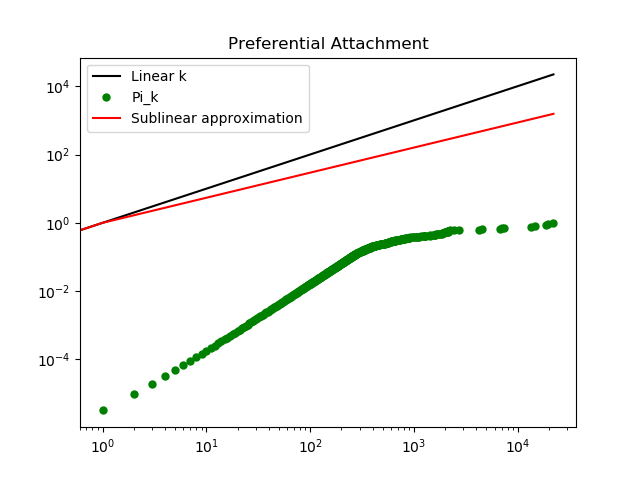

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


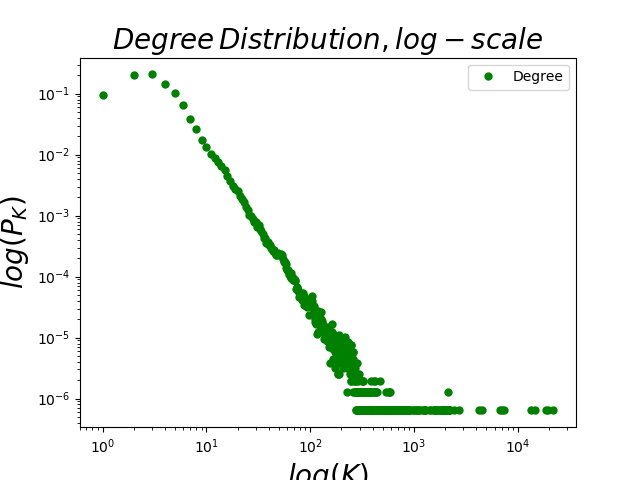

In respect to Poisson distribution


<IPython.core.display.Javascript object>

C:\Users\eliab\Anaconda2\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning:

divide by zero encountered in power

C:\Users\eliab\Anaconda2\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning:

divide by zero encountered in power



In [90]:
#some plots

fig=plt.figure()
axx = fig.add_subplot(111)
axx.plot(deg_dist[0],linear_k,'k-')
axx.plot(deg_dist[0],pi_k, 'go', markersize='5')
axx.plot(deg_dist[0],deg_dist[0][:]**alpha, 'r-')
plt.legend(['Linear k','Pi_k','Sublinear approximation'])
plt.xscale('log')
plt.yscale('log')
plt.title('Preferential Attachment')
plt.show()
del fig
del axx

fig=plt.figure()
axx = fig.add_subplot(111)
axx.plot(deg_dist[0][:], deg_dist[1][:], 'go', markersize='5')
plt.legend(['Degree'])
plt.xlabel('$K$', fontsize = 20)
plt.ylabel('$P_K$', fontsize = 20)
plt.title('$Degree\,Distribution$', fontsize = 20)
plt.show()
del fig
del axx

fig=plt.figure()
axx = fig.add_subplot(111)
axx.plot(deg_dist[0][:], deg_dist[1][:], 'go', markersize='5')
plt.legend(['Degree'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$log(K)$', fontsize = 20)
plt.ylabel('$log(P_K)$', fontsize = 20)
plt.title('$Degree\,Distribution, log-scale$', fontsize = 20)
plt.show()
del fig
del axx

print "In respect to Poisson distribution"

fig=plt.figure()
axx =fig.add_subplot(111)
axx.axvline(x=avg_deg,ls='--')
axx.plot(deg_dist[0][:], deg_dist[1][:], 'go', markersize='5')
axx.plot( deg_dist[0][:], poisson.pmf(deg_dist[0][:],avg_deg), 'r-' )
axx.plot( deg_dist[0][:], ((gamma-1)*(min_deg)**(gamma-1))*deg_dist[0][:]**(-gamma), 'k-' )
axx.plot( deg_dist[0][:], ((gamma_2-1)*(min_deg)**(gamma_2-1))*deg_dist[0][:]**(-gamma_2), 'b-' )
plt.legend(['Average Degree','Degree','Poisson','Power Law 1','Power Law 2'])
plt.xscale('log')
plt.yscale('log')
plt.ylim(math.exp(-18),1)
plt.xlabel('$log(K)$', fontsize = 20)
plt.ylabel('$log(P_K)$', fontsize = 20)
plt.title('$Degree\,Distribution, log-scale$', fontsize = 20)
plt.show()
del fig
del axx

In [10]:
deg.argmax()
len(adj[37753])

22142

In [91]:
#clustering with progress timestamp
a=datetime.datetime.now()
local_cluster=np.zeros(len(adj.keys()))
j=1
step=0 
sums=0
for el in adj.keys():

    neigh=adj[el]
    #we can use this to exclude some vertex
    #just put len(neigh)<value
    if len(neigh)<100000 && len(neigh)>0:
        for ele in neigh:
            if ele<>-1:
                temp=adj[ele]
                sums+=len(neigh)-len(np.setdiff1d(neigh,temp,True))
        if len(neigh)>1:
            #I do not need 2* because I count twice every link
            #because I'm working with the adjacency list
            #I found the difference of the number of all my neigh of neigh
            #and the number of elements that are not in my neigh(So I obtain the number
            #of neigh-neigh that is in "root node" neigh list).... in other words it works
            local_cluster[el]=sums/(len(neigh)*(len(neigh)-1))
            sums=0
    step+=1
    if step>=j*100000:
        print step, " over ", N, " in ", datetime.datetime.now()-a
        j+=1

100000  over  1562564  in  0:02:06.872000
200000  over  1562564  in  0:02:42.132000
300000  over  1562564  in  0:03:05.949000
400000  over  1562564  in  0:03:31.872000
500000  over  1562564  in  0:03:55.708000
600000  over  1562564  in  0:04:21.277000
700000  over  1562564  in  0:04:45.676000
800000  over  1562564  in  0:05:08.586000
900000  over  1562564  in  0:05:30.816000
1000000  over  1562564  in  0:05:51.270000
1100000  over  1562564  in  0:06:07.553000
1200000  over  1562564  in  0:06:26.980000
1300000  over  1562564  in  0:06:41.407000
1400000  over  1562564  in  0:06:54.540000
1500000  over  1562564  in  0:07:19.607000


In [100]:
avg_clust= sum(local_cluster)/len(local_cluster)
print "The predicted clustering is: ", avg_deg/N
print "My average clustering is: ", sum(local_cluster)/len(local_cluster)

fig=plt.figure()
axx =fig.add_subplot(111)
axx.plot( adj.keys(), local_cluster, 'b.',markersize='1')
axx.axhline(y=avg_clust, c='r')
plt.legend(['Clustering coeff','Average'])

plt.xlabel('$K$', fontsize = 20)
plt.ylabel('$C$', fontsize = 20)
plt.title('Clustering coefficient', fontsize = 20)
plt.show()
del fig
del axx

The predicted clustering is:  3.53270310703e-06
My average clustering is:  0.0365510763948


<IPython.core.display.Javascript object>

[1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 320, 795, 797, 1011, 1012]
[1002, 163657, 1012, 178750, 452822, 1009]


In [93]:
#Done but not tested!
#Too much time demanding
#It's right for undirected as if I start from A
#and go to B, if C close a triangle with A it's in the list of the adjacency
#elements of A.

#a=datetime.datetime.now()
#sums=0.
#denom=0.
#step=0
#j=1
#for el in adj.keys():
#    adj_adj=[]
#    neigh=adj[el]
#    #we can use this to exclude some vertex
#    #just put len(neigh)<value
#    step+=1
#    if len(neigh)>1:
#        for ele in neigh:
#            temp=adj[ele]
#            #adj_adj=[]
#            for neigh_bis in temp:
#                adj_adj.append(neigh_bis)
#        if ~directed:
#            sums+=(len(adj_adj)-len(np.setdiff1d(adj_adj,neigh,True)))
#        else:
#            for neigh_temp in adj_adj:
#                sums+= adj[neigh_temp].count(el)
#                denom+=len(adj[neigh_temp])
#        del adj_adj
#    if step>j*100000:
#        print step
#        j+=1
#        print datetime.datetime.now()-a
##print len(adj_adj)
#print sums
#print 3*sums/denom
#print "avg should be near global"

I use BFS to detect cycle, the number of cycle and the number of components with their size in my network.

In [94]:
def BFS(adj, s, cyclic=False, cc=False):
        visited={}
        count_cicle=0
        # Mark all the vertices as not visited
        for i in range(len(adj)):
            visited.setdefault(i, [False,0])
        j=1
        # Create a queue for BFS
        queue = []
        queue.append(s)
        visited[s][0] = True
        cycle=False
        step=1
        while queue:
            s = queue.pop(0)
            for i in adj[s]:                
                if not visited[i][0]:
                    queue.append(i)
                    visited[i] = [True,visited[s][1]+1]
                    step+=1
                else:
                    count_cicle+=1
                    cycle=True
                    if cyclic & ~cc:
                        return cycle
                if step>=j*500000:
                    print "Visited ",step, " nodes for the first time!"
                    j+=1
        if cyclic:
            if cc:
                return count_cicle
            else:
                return cycle
        else:
            return visited

In [95]:
#search strongly connected components
#create array with number of reachable nodes
#the index is the key of the node, like the rest of the code
strong=np.zeros((len(adj.keys()),2))

visited={}
# Mark all the vertices as not visited
for i in range(N):
    visited.setdefault(i, [False,0])

for vertex in visited.keys():
    #if already visited can't lead to max if directed
    #if undirected useless to redo the same path
    if visited[vertex][0]==False:
        temp=BFS(adj,vertex)
        count=sum(1 for x in temp.values() if x[0]==True)
        #to check
        strong[vertex]=[count,sum(x[1] for x in temp.values() if x[0]==True)]
        print "Component of size: ",strong[vertex][0]
        for i in visited.keys():
            if temp[i][0]==True:
                visited[i]=temp[i]
            
#the distance now is from node 0
#as this implementation takes about 4 hrs I've skipped the computation of
#the avg path length
#it can be meaningful check the avg path length from the hub

#for strong[i]!=0 I have number of components(in number of #0)
#and number of elements in the component
comp=0
for i in range(len(strong)):
    if strong[i][0]!=0:
        comp+=1
print "I have ", comp, " components inside my graph"
print "The biggest has size ", max(strong[:,0])
print max(x[1][1] for x in visited.items()), " is the max distance predicted by the first run of BFS"
print (max(strong[:,1]))/max(strong[:,0]), " is the average calculated by the first run of BFS"
print "The predicted distance that covers all the network is: ",math.log(N)/math.log(avg_deg)
print "As gamma= ",gamma," we can also check: ln(ln(N))=", math.log(math.log(N))

#has cycle inside
for vertex in adj.keys():
    cycle=BFS(adj,vertex,True)
    if cycle==True:
        break
if cycle:
    print "The graph has (at least one)cycle"
else:
    print "The graph has no cycle"

Visited  500000  nodes for the first time!
Visited  1000000  nodes for the first time!
Visited  1500000  nodes for the first time!
Component of size:  1562379.0
Component of size:  19.0
Component of size:  3.0
Component of size:  2.0
Component of size:  3.0
Component of size:  2.0
Component of size:  2.0
Component of size:  4.0
Component of size:  2.0
Component of size:  2.0
Component of size:  2.0
Component of size:  4.0
Component of size:  13.0
Component of size:  2.0
Component of size:  2.0
Component of size:  4.0
Component of size:  3.0
Component of size:  6.0
Component of size:  2.0
Component of size:  3.0
Component of size:  6.0
Component of size:  2.0
Component of size:  2.0
Component of size:  3.0
Component of size:  2.0
Component of size:  3.0
Component of size:  5.0
Component of size:  3.0
Component of size:  2.0
Component of size:  3.0
Component of size:  4.0
Component of size:  3.0
Component of size:  3.0
Component of size:  3.0
Component of size:  6.0
Component of size:  2

Network robustness:


By using the well known value for my coefficient as I have already derived the "shape" of my network I can get the critical threshold for my network.

In [96]:
#network robustness
#as gamma 2<gamma<3
beta_p=1/(3-gamma)
gamma_p = -1
f_c_ER= 1-1/avg_deg
f_c=1-1/(second_moment_alt/avg_deg-1)
print "Critical threshold: ", f_c
f_c_alt=1-1/(((gamma-2)/(3-gamma))*min_deg**(gamma-2)*max(deg)**(3-gamma)-1)
print "Alternative critical threshold: ",f_c_alt
print "We also have that f_c=",f_c, " >> ",f_c_ER,"=f_c_ER"

kappa=second_moment/avg_deg
kappa_bis= (gamma-2)/(3-gamma)*max(deg)**(3-gamma)*min_deg**(gamma-2)
print "Kappa: ",kappa_bis
print "Since ", kappa," >> ", 2, " so I expect a big cluster as I've found with BFS"

Critical threshold:  0.998752228923
Alternative critical threshold:  0.998653462534
We also have that f_c= 0.998752228923  >>  0.818843031162 =f_c_ER
Kappa:  743.645507913
Since  254.050547275  >>  2  so I expect a big cluster as I've found with BFS


<IPython.core.display.Javascript object>


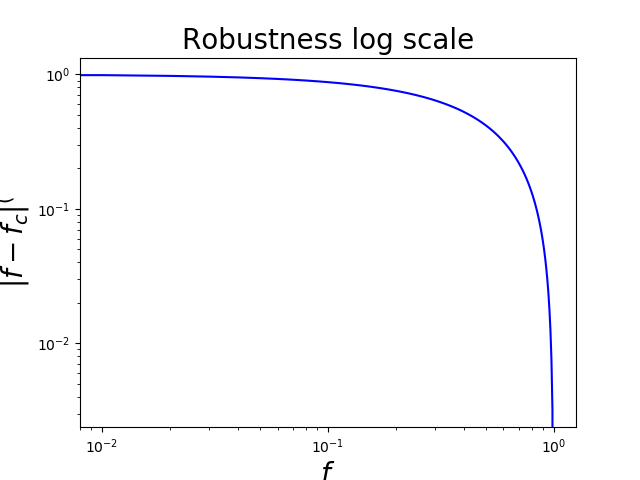

<IPython.core.display.Javascript object>


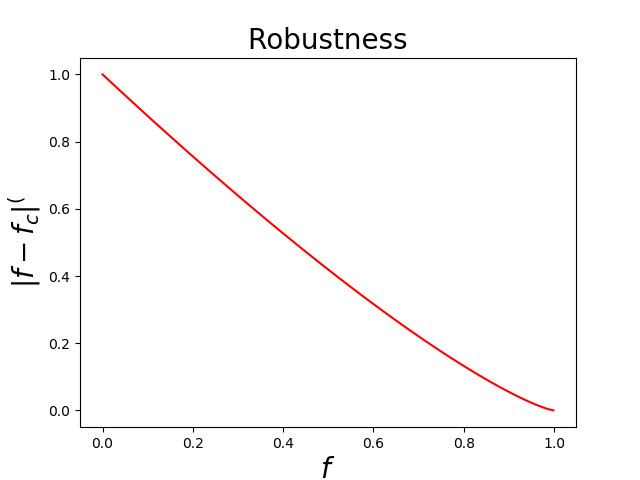

In [97]:
#plot
X = np.linspace(0, f_c, 100, endpoint=True)
Y=[]
Z=[]
for i in X:
    Y.append(math.pow(math.fabs((i-f_c)), beta_p)/math.pow(math.fabs(f_c),beta_p))
    Z.append(math.pow(math.fabs((i-f_c)), beta_p))

fig=plt.figure()
axx=fig.add_subplot(111)
axx.plot(X, Y, 'b-')
plt.ylabel('$|f-f_c|^(\beta_p)/(f_c)^(\beta_p)$', fontsize = 20)
plt.xlabel('$f$', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.title('Robustness log scale', fontsize = 20)
plt.show()
del fig
del axx

fig=plt.figure()
axx=fig.add_subplot(111)
#axx.plot(X, Y, 'b-')
axx.plot(X, Y, 'r-')
plt.ylabel('$|f-f_c|^(\beta_p)$', fontsize = 20)
plt.xlabel('$f$', fontsize = 20)
plt.title('Robustness', fontsize = 20)
plt.show()
del fig
del axx

In [99]:
a=BFS(adj,0,True,True)
print a

Visited  500000  nodes for the first time!
Visited  1000000  nodes for the first time!
Visited  1500000  nodes for the first time!
7062824
